In [46]:
'''
Under Sampling
'''

'\nUnder Sampling\n'

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [48]:
df=pd.read_csv("creditcard.csv")
df.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [50]:
df["Amount"].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

<Axes: xlabel='Amount', ylabel='Density'>

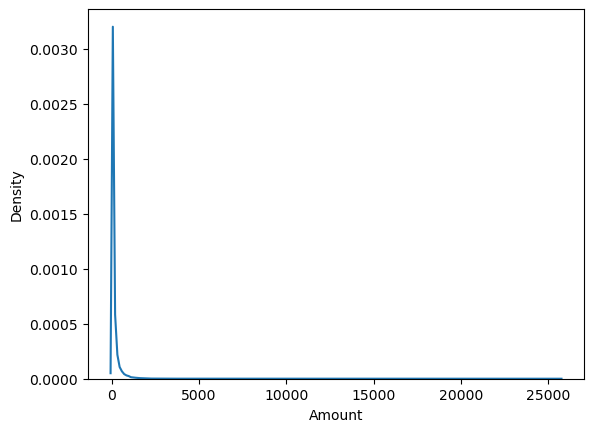

In [51]:
sns.kdeplot(df["Amount"])

<Axes: ylabel='Amount'>

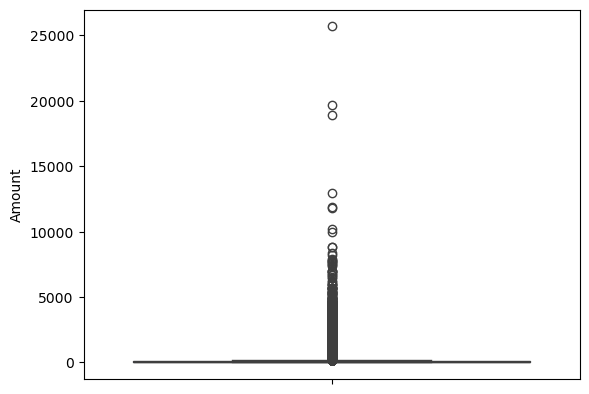

In [52]:
sns.boxplot(df["Amount"])

In [53]:
df["Class"].value_counts()
# Highly imbalanced data availabe for us.

Class
0    284315
1       492
Name: count, dtype: int64

In [54]:
valid=df[df["Class"]==0]
fraud=df[df["Class"]==1]

In [55]:
valid.shape

(284315, 31)

In [56]:
fraud.shape

(492, 31)

In [57]:
# undersampling for valid transaction.
valid=valid.sample(492)

In [58]:
new_df=pd.concat([valid,fraud],ignore_index=1)
new_df.shape

(984, 31)

In [59]:
new_df["Class"].value_counts()

Class
0    492
1    492
Name: count, dtype: int64

In [60]:
features=new_df.drop(["Time","Class"],axis=1)
target=new_df["Class"]

In [61]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(
    features, target, test_size=0.20, random_state=0) 

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression


In [63]:
# to deal with overfitting apply pruning technique
parameters={
    "n_estimators":[60,90,150],
    "max_depth":list(range(1,4)), # 1,2,3
    "min_samples_split":list(range(1,4)), # 1,2,3
    "min_samples_leaf":list(range(2,4)) 
}

In [64]:
global model
def mymodel(model):
    model.fit(xtrain, ytrain)
    ypred = model.predict(xtest)
    
    print(f"Training Score : {model.score(xtrain, ytrain)}")
    print(f"Testing Score : {model.score(xtest, ytest)}")
    
    c = pd.DataFrame(
        confusion_matrix(ytest, ypred),
        index=["Valid", "Fraud"],
        columns=["Valid", "Fraud"]
    )
    print(f"Confusion Matrix : \n{c}")
    print("Classification Report : \n", classification_report(ytest, ypred))

In [65]:
mymodel(RandomForestClassifier()) 

Training Score : 1.0
Testing Score : 0.9441624365482234
Confusion Matrix : 
       Valid  Fraud
Valid     90      1
Fraud     10     96
Classification Report : 
               precision    recall  f1-score   support

           0       0.90      0.99      0.94        91
           1       0.99      0.91      0.95       106

    accuracy                           0.94       197
   macro avg       0.94      0.95      0.94       197
weighted avg       0.95      0.94      0.94       197



In [66]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
model = RandomForestClassifier().fit(xtrain, ytrain) 
ypred_proba = model.predict_proba(xtest)[:, 1]
print(f"ROC_AUC_Score : {roc_auc_score(ytest, ypred_proba)}")

ROC_AUC_Score : 0.9780219780219781


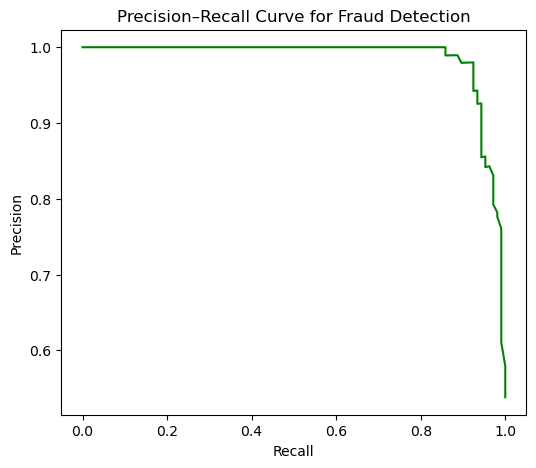

In [67]:
from sklearn.metrics import precision_recall_curve, auc
prec, rec, _ = precision_recall_curve(ytest, ypred_proba)
pr_auc = auc(rec, prec)
plt.figure(figsize=(6,5))
plt.plot(rec, prec, color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve for Fraud Detection')
plt.show()

In [68]:
from sklearn.model_selection import GridSearchCV

parameters = {
    "n_estimators": [150],         # More trees for stability
    "max_depth": [8],              # Deep enough for fraud patterns
    "min_samples_split": [5],      # Balanced splits
    "min_samples_leaf": [1], 
}
clf = GridSearchCV(RandomForestClassifier(),parameters, verbose=2)
clf.fit(xtrain, ytrain)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.4s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.3s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.3s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.3s
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=   0.3s


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [8], 'min_samples_leaf': [1],
                         'min_samples_split': [5], 'n_estimators': [150]},
             verbose=2)

In [69]:
c=mymodel(clf.best_estimator_)
c

Training Score : 0.9872935196950444
Testing Score : 0.934010152284264
Confusion Matrix : 
       Valid  Fraud
Valid     91      0
Fraud     13     93
Classification Report : 
               precision    recall  f1-score   support

           0       0.88      1.00      0.93        91
           1       1.00      0.88      0.93       106

    accuracy                           0.93       197
   macro avg       0.94      0.94      0.93       197
weighted avg       0.94      0.93      0.93       197



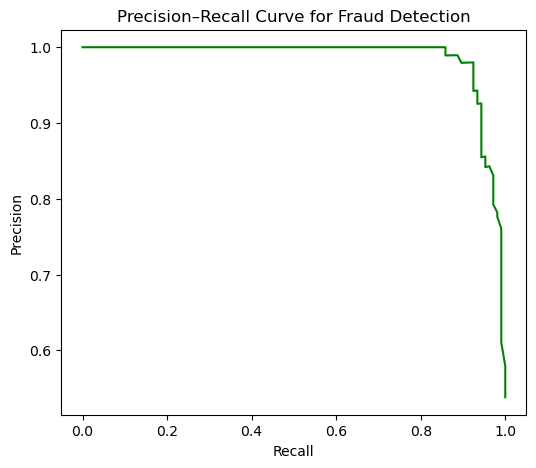

In [70]:
prec, rec, _ = precision_recall_curve(ytest, ypred_proba)
pr_auc = auc(rec, prec)
plt.figure(figsize=(6,5))
plt.plot(rec, prec, color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve for Fraud Detection')
plt.show()

In [71]:
from sklearn.svm import SVC

In [72]:
mymodel(SVC())

Training Score : 0.7916137229987293
Testing Score : 0.700507614213198
Confusion Matrix : 
       Valid  Fraud
Valid     84      7
Fraud     52     54
Classification Report : 
               precision    recall  f1-score   support

           0       0.62      0.92      0.74        91
           1       0.89      0.51      0.65       106

    accuracy                           0.70       197
   macro avg       0.75      0.72      0.69       197
weighted avg       0.76      0.70      0.69       197



In [73]:
parameters={
    "C":[0.01,0.1,1.0,10],
    "gamma":[0.01,0.1,1.0,10],
    "kernel":['rbf','linear']
}

In [74]:
clf=GridSearchCV(SVC(),parameters,verbose=2)
clf.fit(xtrain,ytrain)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END .....................C=0.01, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.01, gamma=0.01, kernel=linear; total time=   0.0s
[CV] END ..................C=0.01, gamma=0.01, kernel=linear; total time=   0.4s
[CV] END ..................C=0.01, gamma=0.01, kernel=linear; total time=   0.1s
[CV] END ..................C=0.01, gamma=0.01, kernel=linear; total time=   0.2s
[CV] END ..................C=0.01, gamma=0.01, kernel=linear; total time=   0.2s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1.0, 10],
                         'gamma': [0.01, 0.1, 1.0, 10],
                         'kernel': ['rbf', 'linear']},
             verbose=2)

In [75]:
svc=mymodel(clf.best_estimator_)
svc

Training Score : 0.9466327827191868
Testing Score : 0.9390862944162437
Confusion Matrix : 
       Valid  Fraud
Valid     91      0
Fraud     12     94
Classification Report : 
               precision    recall  f1-score   support

           0       0.88      1.00      0.94        91
           1       1.00      0.89      0.94       106

    accuracy                           0.94       197
   macro avg       0.94      0.94      0.94       197
weighted avg       0.95      0.94      0.94       197



In [76]:
from sklearn.ensemble import GradientBoostingClassifier

In [77]:
gb=mymodel(GradientBoostingClassifier())

Training Score : 1.0
Testing Score : 0.9441624365482234
Confusion Matrix : 
       Valid  Fraud
Valid     90      1
Fraud     10     96
Classification Report : 
               precision    recall  f1-score   support

           0       0.90      0.99      0.94        91
           1       0.99      0.91      0.95       106

    accuracy                           0.94       197
   macro avg       0.94      0.95      0.94       197
weighted avg       0.95      0.94      0.94       197



In [78]:
!pip install xgboost

In [79]:
import xgboost as xgb
from xgboost import XGBClassifier

In [80]:
xgb=mymodel(XGBClassifier(n_estimators=20))#Hyperparameter Tuning

Training Score : 1.0
Testing Score : 0.9441624365482234
Confusion Matrix : 
       Valid  Fraud
Valid     88      3
Fraud      8     98
Classification Report : 
               precision    recall  f1-score   support

           0       0.92      0.97      0.94        91
           1       0.97      0.92      0.95       106

    accuracy                           0.94       197
   macro avg       0.94      0.95      0.94       197
weighted avg       0.95      0.94      0.94       197

